In [ ]:
# Also added currency data and bond yields since original

In [2]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import stldecompose

Using TensorFlow backend.


In [3]:
data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data_orig.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,ZAR.X.Low,ZAR.X.Close,ZAR.X.Volume,ZAR.X.Adjusted,RUB.X.Open,RUB.X.High,RUB.X.Low,RUB.X.Close,RUB.X.Volume,RUB.X.Adjusted
992,2019-06-04,172.029999,174.970001,171.369995,174.910004,47797800,174.910004,181.100006,193.979996,179.610001,...,14.6112,14.6273,0,14.6273,65.116699,65.343002,64.935699,65.129997,0,65.129997
993,2019-06-05,176.580002,176.610001,174.380005,176.210007,34412700,176.210007,198.679993,201.279999,191.850006,...,14.8321,14.8352,0,14.8352,65.287102,65.328003,65.008003,65.278503,0,65.278503
994,2019-06-06,176.509995,178.039993,175.729996,177.610001,29913200,177.610001,204.440002,211.000000,201.800003,...,14.8953,15.0037,0,15.0037,65.045197,65.136002,64.732002,65.032799,0,65.032799
995,2019-06-07,178.559998,181.770004,178.330002,181.039993,45868600,181.039993,205.000000,210.839996,203.500000,...,0.0000,0.0000,0,0.0000,0.000000,0.000000,0.000000,0.000000,0,0.000000
996,2019-06-08,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.0000,0,0.0000,0.000000,0.000000,0.000000,0.000000,0,0.000000


In [4]:
vol_data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility.csv')
vol_data_orig.tail()

,Index,volatilityQQQ,volatilityTSLA,volatilityMSFT,volatilityINTC,volatilityAAPL,volatilityNFLX,volatilityAMZN,volatilityFB,volatilityGOOG,...,volatilityHKD=X,volatilitySGD=X,volatilityINR=X,volatilityMXN=X,volatilityPHP=X,volatilityIDR=X,volatilityTHB=X,volatilityMYR=X,volatilityZAR=X,volatilityRUB=X
992,2019-06-04,0.236161,0.628139,0.268701,0.281585,0.277755,0.378624,0.333670,0.491539,0.356938,...,0.008461,0.043859,0.082009,0.141995,0.082401,0.068891,0.052323,0.030123,0.173064,0.078079
993,2019-06-05,0.244384,0.536080,0.297374,0.276320,0.277110,0.369766,0.337870,0.492750,0.350358,...,0.008465,0.044029,0.082456,0.145289,0.077390,0.069230,0.057071,0.030085,0.181973,0.069414
994,2019-06-06,0.237914,0.585434,0.303501,0.276694,0.265918,0.349971,0.331952,0.488919,0.357443,...,0.008471,0.042626,0.071099,0.150609,0.070007,0.066401,0.057093,0.043426,0.181317,0.062928
995,2019-06-07,0.260007,0.561922,0.334232,0.294798,0.287668,0.352532,0.372499,0.528088,0.393389,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
996,2019-06-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
data_orig = data_orig\
  .merge(vol_data_orig, how="inner", left_on=data_orig.Index, right_on=vol_data_orig.Index).fillna(method="ffill")\
  .drop(["key_0", "Index_y"], axis=1)\
  .rename(columns={'Index_x':'Index'})

In [6]:
list(data_orig.columns)

['Index',
 'QQQ.Open',
 'QQQ.High',
 'QQQ.Low',
 'QQQ.Close',
 'QQQ.Volume',
 'QQQ.Adjusted',
 'TSLA.Open',
 'TSLA.High',
 'TSLA.Low',
 'TSLA.Close',
 'TSLA.Volume',
 'TSLA.Adjusted',
 'MSFT.Open',
 'MSFT.High',
 'MSFT.Low',
 'MSFT.Close',
 'MSFT.Volume',
 'MSFT.Adjusted',
 'INTC.Open',
 'INTC.High',
 'INTC.Low',
 'INTC.Close',
 'INTC.Volume',
 'INTC.Adjusted',
 'AAPL.Open',
 'AAPL.High',
 'AAPL.Low',
 'AAPL.Close',
 'AAPL.Volume',
 'AAPL.Adjusted',
 'NFLX.Open',
 'NFLX.High',
 'NFLX.Low',
 'NFLX.Close',
 'NFLX.Volume',
 'NFLX.Adjusted',
 'AMZN.Open',
 'AMZN.High',
 'AMZN.Low',
 'AMZN.Close',
 'AMZN.Volume',
 'AMZN.Adjusted',
 'FB.Open',
 'FB.High',
 'FB.Low',
 'FB.Close',
 'FB.Volume',
 'FB.Adjusted',
 'GOOG.Open',
 'GOOG.High',
 'GOOG.Low',
 'GOOG.Close',
 'GOOG.Volume',
 'GOOG.Adjusted',
 'SQ.Open',
 'SQ.High',
 'SQ.Low',
 'SQ.Close',
 'SQ.Volume',
 'SQ.Adjusted',
 'TWTR.Open',
 'TWTR.High',
 'TWTR.Low',
 'TWTR.Close',
 'TWTR.Volume',
 'TWTR.Adjusted',
 'DATA.Open',
 'DATA.High',
 '

In [7]:
from urllib.request import *
from io import StringIO
import pandas as pd

def df_from_fred(setname):
    # Make GET Request
    response = urlopen(url_for(setname))
    # Read response data
    data = response.read()
    # Convert binary text to utf-8
    text = data.decode('utf-8')
    # Convert text file to pandas dataframe
    TEXTDATA = StringIO(text)
    df = pd.read_csv(TEXTDATA, sep=",")
    return df

def url_for(series):
    """function takes FRED series name as input. For example, GDPC1, or HOUST."""
    return "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=968&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id="+series+"&scale=left&cosd=1947-01-01&coed=2019-01-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-05-07&revision_date=2019-05-07&nd=1947-01-01"


In [8]:
# Vital Economic indicators: https://gist.github.com/ngopal/262fce10a7fa4a8467f0c61a13c85dc5
GDPC1 = df_from_fred("GDPC1")
time.sleep(5)
M2 = df_from_fred("M2")
time.sleep(5)
CPALTT01USQ657N = df_from_fred("CPALTT01USQ657N")
time.sleep(5)
PPIACO = df_from_fred("PPIACO")
time.sleep(5)
UMCSENT = df_from_fred("UMCSENT")
time.sleep(5)
PAYEMS = df_from_fred("PAYEMS")
time.sleep(5)
RRSFS = df_from_fred("RRSFS")
time.sleep(5)
HOUST = df_from_fred("HOUST")
time.sleep(5)
ISRATIO = df_from_fred("ISRATIO")
time.sleep(5)
SP500 = df_from_fred("SP500")
time.sleep(5)

# Thoughts
FEDFUNDS = df_from_fred("FEDFUNDS")
time.sleep(5)
UNRATE = df_from_fred("UNRATE")
time.sleep(5)
T10Y2Y = df_from_fred("T10Y2Y")
time.sleep(5)
CBBTCUSD = df_from_fred("CBBTCUSD")
time.sleep(5)

# Others
IPMAN = df_from_fred("IPMAN")
time.sleep(5)
MPU9900063 = df_from_fred("MPU9900063")
time.sleep(5)
PCU33443344 = df_from_fred("PCU33443344")
time.sleep(5)
MEHOINUSA672N = df_from_fred("MEHOINUSA672N")
time.sleep(5)
TCMDO = df_from_fred("TCMDO")
time.sleep(5)
FGTCMDODNS = df_from_fred("FGTCMDODNS")
time.sleep(5)
ADSLFAA027N = df_from_fred("ADSLFAA027N")
time.sleep(5)
NCBCMDPMVCE = df_from_fred("NCBCMDPMVCE")
time.sleep(5)
FGCCSAQ027S = df_from_fred("FGCCSAQ027S")
time.sleep(5)
ASTNITA = df_from_fred("ASTNITA")
time.sleep(5)
PCETRIM12M159SFRBDAL = df_from_fred("PCETRIM12M159SFRBDAL")
DAAA = df_from_fred("DAAA")
time.sleep(5)
USSLIND = df_from_fred("USSLIND")
time.sleep(5)
IRLTLT01USM156N = df_from_fred("IRLTLT01USM156N")
time.sleep(5)

# IPMAN, MPU9900063, PCU33443344, MEHOINUSA672N, TCMDO, FGTCMDODNS, ADSLFAA027N, NCBCMDPMVCE, FGCCSAQ027S, ASTNITA

In [9]:
data_orig = data_orig\
  .merge(GDPC1, how="left", left_on=data_orig.Index, right_on=GDPC1.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(M2, how="left", left_on=data_orig.Index, right_on=M2.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CPALTT01USQ657N, how="left", left_on=data_orig.Index, right_on=CPALTT01USQ657N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PPIACO, how="left", left_on=data_orig.Index, right_on=PPIACO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UMCSENT, how="left", left_on=data_orig.Index, right_on=UMCSENT.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PAYEMS, how="left", left_on=data_orig.Index, right_on=PAYEMS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(RRSFS, how="left", left_on=data_orig.Index, right_on=RRSFS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(HOUST, how="left", left_on=data_orig.Index, right_on=HOUST.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ISRATIO, how="left", left_on=data_orig.Index, right_on=ISRATIO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCETRIM12M159SFRBDAL, how="left", left_on=data_orig.Index, right_on=PCETRIM12M159SFRBDAL.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ASTNITA, how="left", left_on=data_orig.Index, right_on=ASTNITA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGCCSAQ027S, how="left", left_on=data_orig.Index, right_on=FGCCSAQ027S.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(NCBCMDPMVCE, how="left", left_on=data_orig.Index, right_on=NCBCMDPMVCE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ADSLFAA027N, how="left", left_on=data_orig.Index, right_on=ADSLFAA027N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGTCMDODNS, how="left", left_on=data_orig.Index, right_on=FGTCMDODNS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(TCMDO, how="left", left_on=data_orig.Index, right_on=TCMDO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MEHOINUSA672N, how="left", left_on=data_orig.Index, right_on=MEHOINUSA672N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCU33443344, how="left", left_on=data_orig.Index, right_on=PCU33443344.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MPU9900063, how="left", left_on=data_orig.Index, right_on=MPU9900063.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(IPMAN, how="left", left_on=data_orig.Index, right_on=IPMAN.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(SP500, how="left", left_on=data_orig.Index, right_on=SP500.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FEDFUNDS, how="left", left_on=data_orig.Index, right_on=FEDFUNDS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UNRATE, how="left", left_on=data_orig.Index, right_on=UNRATE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(T10Y2Y, how="left", left_on=data_orig.Index, right_on=T10Y2Y.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CBBTCUSD, how="left", left_on=data_orig.Index, right_on=CBBTCUSD.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(DAAA, how="left", left_on=data_orig.Index, right_on=DAAA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(USSLIND, how="left", left_on=data_orig.Index, right_on=USSLIND.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(IRLTLT01USM156N, how="left", left_on=data_orig.Index, right_on=IRLTLT01USM156N.DATE).fillna(method="ffill")\
  .fillna(-1)

In [10]:
data_orig.drop(['DATE_y', 'DATE_x', 'key_0'], axis=1, inplace=True)

In [11]:
list(data_orig.columns)

['Index',
 'QQQ.Open',
 'QQQ.High',
 'QQQ.Low',
 'QQQ.Close',
 'QQQ.Volume',
 'QQQ.Adjusted',
 'TSLA.Open',
 'TSLA.High',
 'TSLA.Low',
 'TSLA.Close',
 'TSLA.Volume',
 'TSLA.Adjusted',
 'MSFT.Open',
 'MSFT.High',
 'MSFT.Low',
 'MSFT.Close',
 'MSFT.Volume',
 'MSFT.Adjusted',
 'INTC.Open',
 'INTC.High',
 'INTC.Low',
 'INTC.Close',
 'INTC.Volume',
 'INTC.Adjusted',
 'AAPL.Open',
 'AAPL.High',
 'AAPL.Low',
 'AAPL.Close',
 'AAPL.Volume',
 'AAPL.Adjusted',
 'NFLX.Open',
 'NFLX.High',
 'NFLX.Low',
 'NFLX.Close',
 'NFLX.Volume',
 'NFLX.Adjusted',
 'AMZN.Open',
 'AMZN.High',
 'AMZN.Low',
 'AMZN.Close',
 'AMZN.Volume',
 'AMZN.Adjusted',
 'FB.Open',
 'FB.High',
 'FB.Low',
 'FB.Close',
 'FB.Volume',
 'FB.Adjusted',
 'GOOG.Open',
 'GOOG.High',
 'GOOG.Low',
 'GOOG.Close',
 'GOOG.Volume',
 'GOOG.Adjusted',
 'SQ.Open',
 'SQ.High',
 'SQ.Low',
 'SQ.Close',
 'SQ.Volume',
 'SQ.Adjusted',
 'TWTR.Open',
 'TWTR.High',
 'TWTR.Low',
 'TWTR.Close',
 'TWTR.Volume',
 'TWTR.Adjusted',
 'DATA.Open',
 'DATA.High',
 '

In [12]:
ticker_lookup = dict([(i[1].split('.')[0], int(i[0])) for i in enumerate(list(data_orig.columns)) if (('Open' in i[1]) or ("volatility" in i[1]))])
ticker_lookup

{'AAPL': 25,
 'AMD': 73,
 'AMZN': 37,
 'AUDUSD': 343,
 'BABA': 193,
 'BP': 199,
 'BTCUSD': 313,
 'BUD': 205,
 'CNY': 397,
 'DATA': 67,
 'DIS': 151,
 'DUK': 163,
 'ETHUSD': 319,
 'EURCAD': 373,
 'EURCHF': 385,
 'EURGBP': 367,
 'EURHUF': 391,
 'EURJPY': 355,
 'EURSEK': 379,
 'EURUSD': 325,
 'FB': 43,
 'GBPJPY': 361,
 'GBPUSD': 337,
 'GLD': 181,
 'GLW': 211,
 'GOOG': 49,
 'HD': 157,
 'HKD': 403,
 'IDR': 433,
 'INR': 415,
 'INTC': 19,
 'JNJ': 109,
 'JPY': 331,
 'JWN': 97,
 'KO': 115,
 'MSFT': 13,
 'MXN': 421,
 'MYR': 445,
 'NFLX': 31,
 'NVDA': 133,
 'NZDUSD': 349,
 'PANW': 127,
 'PFE': 217,
 'PG': 103,
 'PHP': 427,
 'QQQ': 1,
 'RHT': 139,
 'RUB': 457,
 'SBUX': 79,
 'SFIX': 223,
 'SGD': 409,
 'SLV': 187,
 'SPOT': 169,
 'SQ': 55,
 'STX': 229,
 'T': 235,
 'TGT': 91,
 'THB': 439,
 'TSLA': 7,
 'TWTR': 61,
 'USO': 145,
 'V': 241,
 'VRSN': 121,
 'WDC': 175,
 'WMT': 85,
 'XLB': 253,
 'XLE': 247,
 'XLF': 283,
 'XLI': 259,
 'XLK': 289,
 'XLP': 271,
 'XLRE': 307,
 'XLU': 301,
 'XLV': 277,
 'XLY': 265

In [13]:
data_orig.iloc[:,1:].shift(1)

,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,TSLA.Close,...,MPU9900063,IPMAN,SP500,FEDFUNDS,UNRATE,T10Y2Y,CBBTCUSD,DAAA,USSLIND,IRLTLT01USM156N
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
2,109.449997,109.599998,108.120003,109.500000,50807600.0,106.223091,230.720001,231.380005,219.000000,223.410004,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
3,110.040001,110.180000,108.800003,109.309998,38795200.0,106.038773,226.360001,226.889999,220.000000,223.429993,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
4,107.410004,108.889999,107.410004,108.260002,41891100.0,105.020172,220.000000,220.050003,215.979996,219.039993,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
5,105.949997,107.290001,104.809998,104.870003,61386300.0,101.731651,214.190002,218.440002,213.669998,215.649994,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
6,105.629997,106.290001,103.900002,104.010002,69344000.0,100.897369,217.860001,220.440002,210.770004,211.000000,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
7,104.750000,105.059998,102.730003,104.330002,49767900.0,101.207802,214.009995,214.449997,203.000000,207.850006,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
8,105.330002,106.080002,104.080002,105.540001,46734200.0,102.381592,211.600006,213.740005,205.309998,209.970001,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
9,105.970001,106.230003,101.739998,101.900002,69870700.0,98.850510,212.009995,212.649994,200.000000,200.309998,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000


In [14]:
days_lookback = 1
pct_df = data_orig.iloc[:,1:].shift(days_lookback).fillna(-1)
pct_df

,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,TSLA.Close,...,MPU9900063,IPMAN,SP500,FEDFUNDS,UNRATE,T10Y2Y,CBBTCUSD,DAAA,USSLIND,IRLTLT01USM156N
0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
2,109.449997,109.599998,108.120003,109.500000,50807600.0,106.223091,230.720001,231.380005,219.000000,223.410004,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
3,110.040001,110.180000,108.800003,109.309998,38795200.0,106.038773,226.360001,226.889999,220.000000,223.429993,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
4,107.410004,108.889999,107.410004,108.260002,41891100.0,105.020172,220.000000,220.050003,215.979996,219.039993,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
5,105.949997,107.290001,104.809998,104.870003,61386300.0,101.731651,214.190002,218.440002,213.669998,215.649994,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
6,105.629997,106.290001,103.900002,104.010002,69344000.0,100.897369,217.860001,220.440002,210.770004,211.000000,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
7,104.750000,105.059998,102.730003,104.330002,49767900.0,101.207802,214.009995,214.449997,203.000000,207.850006,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
8,105.330002,106.080002,104.080002,105.540001,46734200.0,102.381592,211.600006,213.740005,205.309998,209.970001,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000
9,105.970001,106.230003,101.739998,101.900002,69870700.0,98.850510,212.009995,212.649994,200.000000,200.309998,...,-0.2,101.2587,1951.224918,0.360000,4.933333,1.078033,409.698242,3.921311,1.556667,1.920000


In [20]:
# data_orig.drop("DATE", axis=1, inplace=True)
# pct_df.drop("DATE", axis=1, inplace=True)
# data_orig.drop("Index", axis=1, inplace=True)
# pct_df.drop("Index", axis=1, inplace=True)

In [21]:
inv_map = {v+'.Open': k for k, v in dict(enumerate(list(ticker_lookup.keys()))).items()}
inv_map

{'AAPL.Open': 4,
 'AMD.Open': 12,
 'AMZN.Open': 6,
 'AUDUSD.Open': 57,
 'BABA.Open': 32,
 'BP.Open': 33,
 'BTCUSD.Open': 52,
 'BUD.Open': 34,
 'CNY.Open': 66,
 'DATA.Open': 11,
 'DIS.Open': 25,
 'DUK.Open': 27,
 'ETHUSD.Open': 53,
 'EURCAD.Open': 62,
 'EURCHF.Open': 64,
 'EURGBP.Open': 61,
 'EURHUF.Open': 65,
 'EURJPY.Open': 59,
 'EURSEK.Open': 63,
 'EURUSD.Open': 54,
 'FB.Open': 7,
 'GBPJPY.Open': 60,
 'GBPUSD.Open': 56,
 'GLD.Open': 30,
 'GLW.Open': 35,
 'GOOG.Open': 8,
 'HD.Open': 26,
 'HKD.Open': 67,
 'IDR.Open': 72,
 'INR.Open': 69,
 'INTC.Open': 3,
 'JNJ.Open': 18,
 'JPY.Open': 55,
 'JWN.Open': 16,
 'KO.Open': 19,
 'MSFT.Open': 2,
 'MXN.Open': 70,
 'MYR.Open': 74,
 'NFLX.Open': 5,
 'NVDA.Open': 22,
 'NZDUSD.Open': 58,
 'PANW.Open': 21,
 'PFE.Open': 36,
 'PG.Open': 17,
 'PHP.Open': 71,
 'QQQ.Open': 0,
 'RHT.Open': 23,
 'RUB.Open': 76,
 'SBUX.Open': 13,
 'SFIX.Open': 37,
 'SGD.Open': 68,
 'SLV.Open': 31,
 'SPOT.Open': 28,
 'SQ.Open': 9,
 'STX.Open': 38,
 'T.Open': 39,
 'TGT.Open': 

In [22]:
# De-trend data
data_orig_detrended = signal.detrend(data_orig)

scaler = MinMaxScaler(feature_range=(0, 1))
# data_mat = scaler.fit_transform(data_orig.iloc[:,1:])
data_mat = scaler.fit_transform(data_orig_detrended)
pctdf_mat = scaler.transform(pct_df)

In [23]:
seq_len = 90 # days to use for prediction
data = np.array((data_mat))

In [24]:
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :] # Create training set

In [25]:
# np.random.shuffle(train)
x_train = result[:int(row), :]
y_train = pctdf_mat[:int(row)] # Needs to be N-day shift
x_test = result[int(row):, :]
y_test = pctdf_mat[int(row):]  # Needs to be N-day shift

[x_train, y_train, x_test, y_test]

[array([[[0.99393191, 0.99393314, 0.99393436, ..., 0.99277454,
          0.99276433, 0.99275413],
         [0.98351642, 0.98355802, 0.98359945, ..., 0.99282531,
          0.99282359, 0.99282186],
         [0.987042  , 0.98707314, 0.98710414, ..., 0.99363477,
          0.99363083, 0.9936269 ],
         ...,
         [0.97923123, 0.97927538, 0.97931934, ..., 0.98920497,
          0.98920382, 0.98920266],
         [0.98487567, 0.98491487, 0.98495391, ..., 0.99355966,
          0.99355742, 0.99355518],
         [0.99049314, 0.99053337, 0.99057343, ..., 0.99943505,
          0.99943296, 0.99943088]],
 
        [[0.98351642, 0.98355802, 0.98359945, ..., 0.99282531,
          0.99282359, 0.99282186],
         [0.987042  , 0.98707314, 0.98710414, ..., 0.99363477,
          0.99363083, 0.9936269 ],
         [0.98560601, 0.98564407, 0.98568196, ..., 0.99399168,
          0.99398919, 0.99398671],
         ...,
         [0.98487567, 0.98491487, 0.98495391, ..., 0.99355966,
          0.99355742, 0.

In [26]:
LAYERS = 30
model = Sequential()

model.add(LSTM(
    input_dim=data.shape[1],
    output_dim=LAYERS,
    return_sequences=True))
# model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(
    LAYERS,
    return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(
    output_dim=y_train.shape[1]))
model.add(Activation('linear'))

start = time.time()
# adam = Adam(lr=0.1)
model.compile(loss='mse', optimizer="adam")
print('compilation time : ', time.time() - start)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 567..., units=30)`
  import sys


compilation time :  0.02002406120300293


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=567)`
  app.launch_new_instance()


In [27]:
MODELNAME = 'multiplemodeltest_medusa_itemized_6-8-2019'
# earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1, epsilon=1e-4, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [30]:
VALIDATIONSIZE = 0.10
EPOCHS = 500
attempts = 0
while attempts < 10:
    if MODELNAME+'_best.hdf5' in os.listdir('./models/'):
        print("found pre-existing -- loading")
        while min(history.history.get("val_loss")) > 0.001:
            print("attempt:", attempts)
            model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5')
            earlyStopping = EarlyStopping(monitor='val_loss', patience=260, verbose=0, mode='min')
            reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=250, verbose=1, epsilon=1e-4, mode='min')
            history = model.fit(
                x_train,
                y_train,
                batch_size=1024,
                nb_epoch=EPOCHS,
                validation_split=VALIDATIONSIZE,
                callbacks = [reduce_lr_loss, earlyStopping, mcp_save],
                shuffle=True)
            attempts += 1
    else:
        print("running first time")
        earlyStopping = EarlyStopping(monitor='val_loss', patience=26, verbose=0, mode='min')
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, verbose=1, epsilon=1e-4, mode='min')
        history = model.fit(
            x_train,
            y_train,
            batch_size=1024,
            nb_epoch=EPOCHS,
            validation_split=VALIDATIONSIZE,
            callbacks = [reduce_lr_loss, earlyStopping, mcp_save],
            shuffle=True)

found pre-existing -- loading
attempt: 0


/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 733 samples, validate on 82 samples
Epoch 1/500
733/733 [==============================] - 6s 8ms/step - loss: 0.2231 - val_loss: 0.1507
Epoch 2/500
733/733 [==============================] - 2s 3ms/step - loss: 0.2136 - val_loss: 0.1734
Epoch 3/500
733/733 [==============================] - 2s 3ms/step - loss: 0.1906 - val_loss: 0.2412
Epoch 4/500
733/733 [==============================] - 2s 3ms/step - loss: 0.1791 - val_loss: 0.4506
Epoch 5/500
733/733 [==============================] - 2s 3ms/step - loss: 0.1649 - val_loss: 0.6962
Epoch 6/500
733/733 [==============================] - 2s 3ms/step - loss: 0.1513 - val_loss: 1.0443
Epoch 7/500
733/733 [==============================] - 2s 3ms/step - loss: 0.1376 - val_loss: 1.2489
Epoch 8/500
733/733 [==============================] - 2s 3ms/step - loss: 0.1293 - val_loss: 1.2983
Epoch 9/500
733/733 [==============================] - 2s 3ms/step - loss: 0.1199 - val_loss: 1.3271
Epoch 10/500
733/733 [========================

Epoch 81/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0518 - val_loss: 1.0936
Epoch 82/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0530 - val_loss: 1.0896
Epoch 83/500
733/733 [==============================] - 2s 2ms/step - loss: 0.0524 - val_loss: 1.0858
Epoch 84/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0513 - val_loss: 1.0808
Epoch 85/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0512 - val_loss: 1.0755
Epoch 86/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0500 - val_loss: 1.0703
Epoch 87/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0526 - val_loss: 1.0652
Epoch 88/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0508 - val_loss: 1.0596
Epoch 89/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0523 - val_loss: 1.0538
Epoch 90/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0491

Epoch 161/500
733/733 [==============================] - 3s 4ms/step - loss: 0.0414 - val_loss: 0.0674
Epoch 162/500
733/733 [==============================] - 3s 4ms/step - loss: 0.0425 - val_loss: 0.0663
Epoch 163/500
733/733 [==============================] - 3s 5ms/step - loss: 0.0407 - val_loss: 0.0649
Epoch 164/500
733/733 [==============================] - 3s 4ms/step - loss: 0.0399 - val_loss: 0.0642
Epoch 165/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0415 - val_loss: 0.0629
Epoch 166/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0427 - val_loss: 0.0619
Epoch 167/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0392 - val_loss: 0.0609
Epoch 168/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0409 - val_loss: 0.0587
Epoch 169/500
733/733 [==============================] - 3s 4ms/step - loss: 0.0392 - val_loss: 0.0562
Epoch 170/500
733/733 [==============================] - 3s 4ms/step - lo

Epoch 241/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0338 - val_loss: 0.0256
Epoch 242/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0322 - val_loss: 0.0262
Epoch 243/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0325 - val_loss: 0.0270
Epoch 244/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0342 - val_loss: 0.0288
Epoch 245/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0348 - val_loss: 0.0314
Epoch 246/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0323 - val_loss: 0.0339
Epoch 247/500
733/733 [==============================] - 3s 3ms/step - loss: 0.0332 - val_loss: 0.0360
Epoch 248/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0354 - val_loss: 0.0391
Epoch 249/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0312 - val_loss: 0.0437
Epoch 250/500
733/733 [==============================] - 2s 3ms/step - lo

Epoch 321/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0305 - val_loss: 0.0510
Epoch 322/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0305 - val_loss: 0.0496
Epoch 323/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0300 - val_loss: 0.0465
Epoch 324/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0296 - val_loss: 0.0432
Epoch 325/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0291 - val_loss: 0.0403
Epoch 326/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0288 - val_loss: 0.0377
Epoch 327/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0285 - val_loss: 0.0347
Epoch 328/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0298 - val_loss: 0.0319
Epoch 329/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0318 - val_loss: 0.0291
Epoch 330/500
733/733 [==============================] - 3s 3ms/step - lo

Epoch 401/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0263 - val_loss: 0.0067
Epoch 402/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0290 - val_loss: 0.0069
Epoch 403/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0297 - val_loss: 0.0066
Epoch 404/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0306 - val_loss: 0.0060
Epoch 405/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0281 - val_loss: 0.0058
Epoch 406/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0271 - val_loss: 0.0054
Epoch 407/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0278 - val_loss: 0.0051
Epoch 408/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0270 - val_loss: 0.0046
Epoch 409/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0298 - val_loss: 0.0044
Epoch 410/500
733/733 [==============================] - 2s 3ms/step - lo

Epoch 481/500
733/733 [==============================] - 3s 4ms/step - loss: 0.0265 - val_loss: 0.0033
Epoch 482/500
733/733 [==============================] - 3s 4ms/step - loss: 0.0266 - val_loss: 0.0031
Epoch 483/500
733/733 [==============================] - 3s 4ms/step - loss: 0.0261 - val_loss: 0.0029
Epoch 484/500
733/733 [==============================] - 3s 4ms/step - loss: 0.0266 - val_loss: 0.0029
Epoch 485/500
733/733 [==============================] - 3s 4ms/step - loss: 0.0272 - val_loss: 0.0030
Epoch 486/500
733/733 [==============================] - 3s 4ms/step - loss: 0.0262 - val_loss: 0.0030
Epoch 487/500
733/733 [==============================] - 3s 4ms/step - loss: 0.0278 - val_loss: 0.0031
Epoch 488/500
733/733 [==============================] - 3s 3ms/step - loss: 0.0250 - val_loss: 0.0031
Epoch 489/500
733/733 [==============================] - 3s 4ms/step - loss: 0.0261 - val_loss: 0.0028
Epoch 490/500
733/733 [==============================] - 3s 3ms/step - lo

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 733 samples, validate on 82 samples
Epoch 1/500
733/733 [==============================] - 7s 10ms/step - loss: 0.0288 - val_loss: 8.8010e-04
Epoch 2/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0261 - val_loss: 7.8396e-04
Epoch 3/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0245 - val_loss: 6.5843e-04
Epoch 4/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0265 - val_loss: 5.9500e-04
Epoch 5/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0278 - val_loss: 5.7308e-04
Epoch 6/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0264 - val_loss: 6.1211e-04
Epoch 7/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0257 - val_loss: 7.2867e-04
Epoch 8/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0265 - val_loss: 7.0647e-04
Epoch 9/500
733/733 [==============================] - 2s 3ms/step - loss: 0.0264 - val_loss: 7.6304e-04
Epoch 10/

KeyboardInterrupt: 

In [31]:
best_model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 

In [32]:
# 5 refers to days of data. 5 days worth. each 1 row has 36 features
days = 5

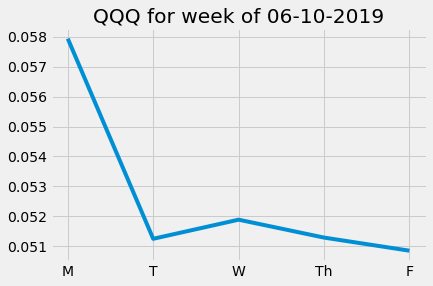

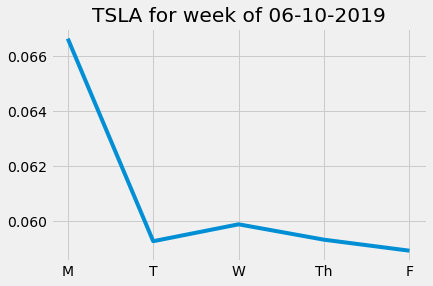

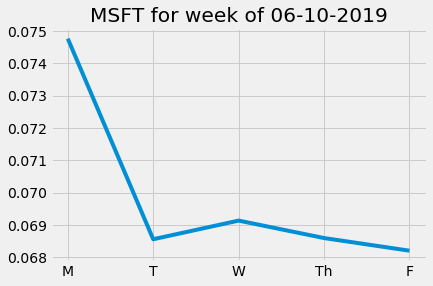

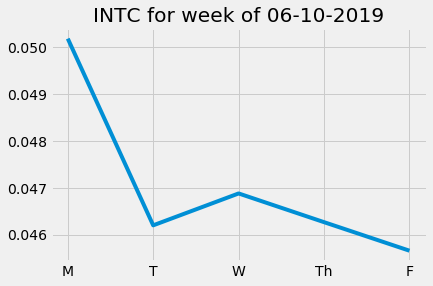

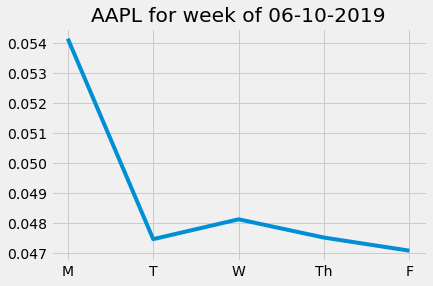

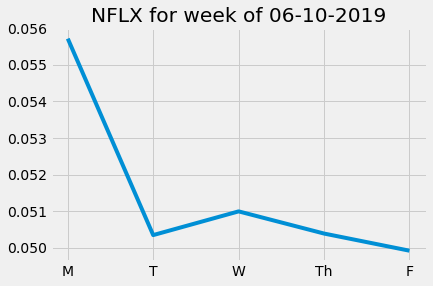

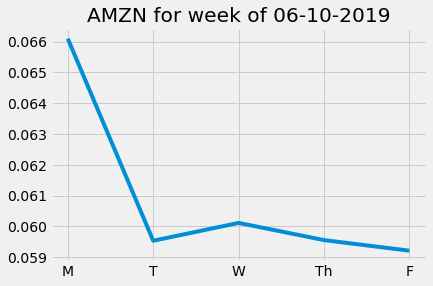

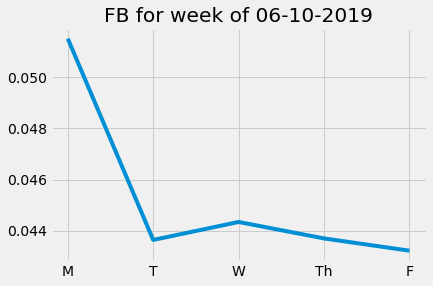

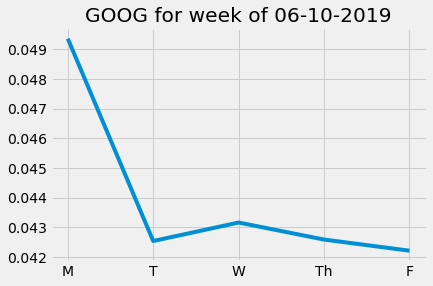

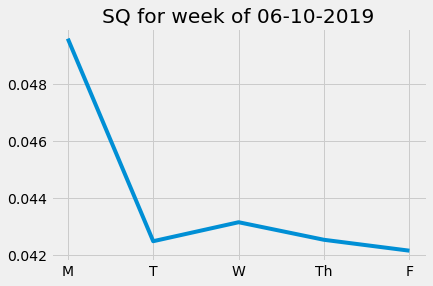

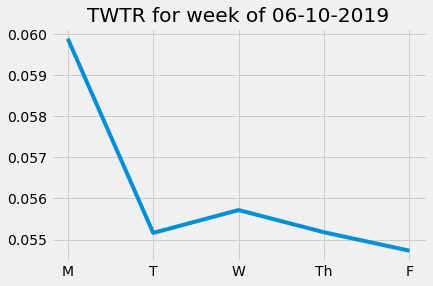

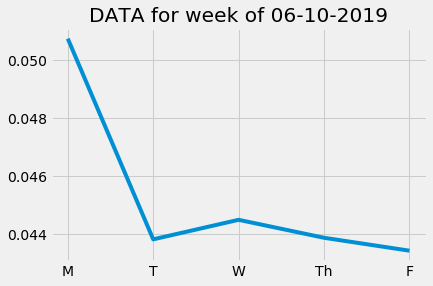

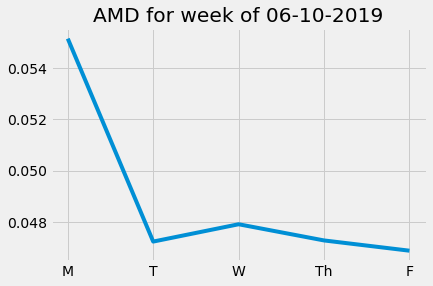

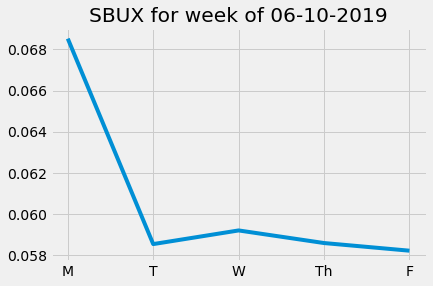

In [ ]:
for t in list(ticker_lookup.keys()):
    plt.style.use('fivethirtyeight')
    plt.title(str(t)+" for week of "+"06-10-2019")
    plt.plot([i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
    plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
    if "volatility" in t:
        plt.savefig('../reports/'+t.split("volatility")[1]+'_volatility_prediction.png')
    else:
        plt.savefig('../reports/'+t+'_prediction.png')
    plt.show()

In [ ]:
t = "QQQ"
plt.style.use('fivethirtyeight')
plt.title(t)
plt.plot([i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
plt.show()

plt.title("Volatility "+t)
plt.plot([i[ticker_lookup["volatility"+t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
plt.show()

In [ ]:
dati = []
prices = [i[ticker_lookup["QQQ"]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))]
for i, b in enumerate(prices):
    datj = []
    for j, s in enumerate(prices):
        datj.append(s - b)
    dati.append(datj)
    
max_found = 0
max_ind = 0
l = 0
for l,k in enumerate(dati):
    print(k, [w for w,n in enumerate(k) if n == max(k)], max(k))
    if max(k) > max_found:
        max_found = max(k)
        max_ind = l
    
print(max_found, l)